<a href="https://colab.research.google.com/github/JanGorczynski/Sentiment_Analysis_project/blob/main/CudaProjekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner
!pip install nltk
!pip install scikit-learn
!pip install seaborn
!pip install gensim

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from keras.models import Sequential, Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import LSTM,CuDNNLSTM, Dropout, Embedding, Conv1D, MultiHeadAttention, Input, Flatten, BatchNormalization, Dropout
from kerastuner import RandomSearch, HyperModel

C:\Users\S7ST3M\AppData\Local\Temp\ipykernel_27504\2036113830.py:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch, HyperModel


In [3]:

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\S7ST3M\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\S7ST3M\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
df = pd.read_csv("IMDB Dataset.csv")

In [5]:
df.columns = ["Review","Sentiment"]

In [6]:
df.head()

,Review,Sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     50000 non-null  object
 1   Sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
df["Sentiment"].value_counts()

Sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [9]:
test = df["Review"][1]
print(test)

A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.


Following fuction takes sentence and preparse it for traning by: <br>
1 Converting the word to lower case <br>
2 Removing html '< br />< br />' tag <br>
3 Removing non letter characters <br>
4 Removing stop words <br>
5 Lemmatizing words eg. gives -> give <br>

In [10]:
def prep_sentence(sentence):
  lemmatizer = WordNetLemmatizer()
  sentence = sentence.lower()
  sentence = sentence.replace("<br /><br />"," ")
  sentence = re.sub("\'", "",sentence)
  sentence = re.sub(r'[^a-z]', ' ', sentence)

  sentence = sentence.split()
  stop_words = set(stopwords.words('english'))
  for word in sentence:
    if word in stop_words:
      sentence.remove(word)
  for i in range(len(sentence)):
    sentence[i] = lemmatizer.lemmatize(sentence[i])

  return " ".join(sentence)

In [11]:
print(prep_sentence(test))

wonderful little production filming technique unassuming very old time bbc fashion give comforting sometimes discomforting sense realism entire piece actor extremely well chosen michael sheen only got polari he all voice pat you truly see seamless editing guided reference williams diary entry only well worth watching it terrificly written performed piece a masterful production one the great master comedy his life the realism really come home the little thing the fantasy the guard rather use the traditional dream technique remains solid disappears it play our knowledge our sens particularly the scene concerning orton halliwell the set particularly their flat halliwells mural decorating every surface terribly well done


In [12]:
print(df["Review"].isnull().sum())
print(df["Sentiment"].isnull().sum())

0
0


In [13]:
df["Processed_review"] = df['Review'].apply(prep_sentence)

In [14]:
df["Processed_review"]

0        one reviewer mentioned after watching oz episo...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically there family little boy jake think t...
4        petter matteis love time money visually stunni...
                               ...                        
49995    thought movie right good job wasnt creative or...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    am catholic taught parochial elementary school...
49998    im going have disagree previous comment side m...
49999    one expects star trek movie be high art fan ex...
Name: Processed_review, Length: 50000, dtype: object

<Axes: xlabel='Processed_review', ylabel='Count'>

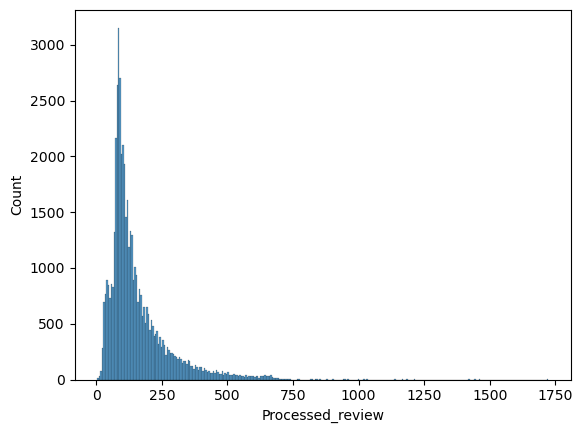

In [15]:
sns.histplot(df["Processed_review"].apply(lambda x: len(x.split())))

In [16]:
y_labels = []
for sentiment in df["Sentiment"]:
  if sentiment == "positive":
    y_labels.append(1)
  else:
    y_labels.append(0)

y_labels = np.array(y_labels)

for i in range(0,10):
  print(y_labels[i],df["Sentiment"][i])

1 positive
1 positive
1 positive
0 negative
1 positive
1 positive
1 positive
0 negative
0 negative
1 positive


In [17]:
maxwords = 10000
max_len = 250
x_data = list(df["Processed_review"])

In [18]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(x_data, y_labels, test_size=0.2, random_state=101)

In [19]:
tokenizer = Tokenizer(num_words=maxwords)
tokenizer.fit_on_texts(X_train_raw)
X_train = tokenizer.texts_to_sequences(X_train_raw)
X_test = tokenizer.texts_to_sequences(X_test_raw)
X_train = np.array(pad_sequences(X_train, maxlen=max_len))
X_test = np.array(pad_sequences(X_test, maxlen=max_len))

In [20]:
print(X_train.shape)
print(X_test.shape)

(40000, 250)
(10000, 250)


In [21]:
def get_len(x):
  for i in range(len(x)):
    if(x[i]!=0):
      return len(x)-i
  return 0

In [22]:
def to_cat(i):
  if(i<0.5):
    return 0
  else:
    return 1

# ATTENTION

Attention based network uses embeding to convert words into numerical vectors for our networks input, embeding layers are also trained, after some epochs they place the words in vector space where distance between them is correlated to their meaning, the closer the words the closer the meaning. Next layers are multihead attention layers. Single attention layer finds relevant information in the data by multiplying queries and keys which essentially is like looking for correlation between words in text. Multihead attention is many attention layers connected parallel to each other. This mechanism has certain advantages over LSTM and CNN models, mainly its not affected by exploding gradients problem, this means that no matter how far 2 words are in the text, network wont have a problem with corelating their meaning. This type of layer is backbone of the Transformer architecture which is used in many NLP aplications like LLM's for example ChatGPT. After multihead attention are fully concted layers and an output layer for making prediction. I used keras tuner to find good set of hyperparameters.

In [23]:
def build(n):
    
    inputs = Input(shape=(250,1))
    
    embeding = Embedding(10000,25)(inputs)
    
    attention = MultiHeadAttention(num_heads=12, key_dim=64)(embeding, embeding)
    
    flatten = Flatten()(attention)
    
    #Rectified Linear Unit f(x)=max(0,x)
    dense = Dense(units=64, activation='relu')(flatten)
    
    for i in range(n):
      dense = Dense(units= 64, activation='relu')(dense)
    
    drop = Dropout(0.4)(dense)
    
    #sigmoid  σ(x)= 1/(1+e^−x​)
    outputs = Dense(units=1, activation='sigmoid')(dense)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=Adam(learning_rate=0.01),loss="binary_crossentropy",metrics = "accuracy")
    return model

In [24]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [25]:
model_atten = build(2)

In [26]:
model_atten.fit(X_train, y_train, epochs=30,batch_size = 256, validation_data=(X_test,y_test), callbacks = [stop_early])

Epoch 1/30
157/157 [==============================] - 62s 385ms/step - loss: 0.5206 - accuracy: 0.7696 - val_loss: 0.2990 - val_accuracy: 0.8750
Epoch 2/30
157/157 [==============================] - 48s 304ms/step - loss: 0.2264 - accuracy: 0.9122 - val_loss: 0.2667 - val_accuracy: 0.8953
Epoch 3/30
157/157 [==============================] - 59s 378ms/step - loss: 0.1871 - accuracy: 0.9268 - val_loss: 0.2910 - val_accuracy: 0.8924
Epoch 4/30
157/157 [==============================] - 48s 307ms/step - loss: 0.1669 - accuracy: 0.9330 - val_loss: 0.3133 - val_accuracy: 0.8862
Epoch 5/30
157/157 [==============================] - 43s 276ms/step - loss: 0.1412 - accuracy: 0.9412 - val_loss: 0.3572 - val_accuracy: 0.8871
Epoch 6/30
157/157 [==============================] - 43s 276ms/step - loss: 0.1176 - accuracy: 0.9515 - val_loss: 0.3968 - val_accuracy: 0.8832
Epoch 7/30
157/157 [==============================] - 50s 318ms/step - loss: 0.1119 - accuracy: 0.9532 - val_loss: 0.4180 - val_ac

In [27]:
predictions =  model_atten.predict(X_test)

313/313 [==============================] - 6s 19ms/step


In [28]:
predictions = [ to_cat(i) for i in predictions]

In [29]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4959
           1       0.89      0.88      0.88      5041

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [30]:
print(pd.DataFrame(confusion_matrix(y_test,predictions),columns = ["Positive values", "Negative values"],
                   index = ["Positive guesses", "Negative guesses"]))

                  Positive values  Negative values
Positive guesses             4383              576
Negative guesses              608             4433


In [31]:
X_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [32]:
def isReviewPositive(text):
    text = prep_sentence(text)
   
    tokenizer.fit_on_texts([text])
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    predictions2 = model_atten.predict(padded_sequences)
    print("raw: ", predictions2[0])
    if to_cat(predictions2[0]) == 0:
        print("Negative review")
        return False
    else:
        print("Positive review")
        return True

In [33]:
print("\nType in review: ")
inputIn = input()
while inputIn != ":q":
    
    isReviewPositive(inputIn)
    
    print("\nType in review: ")
    inputIn = input()


Type in review: 


 this movie was terrific


1/1 [==============================] - 0s 16ms/step
raw:  [0.8912647]
Positive review

Type in review: 


 :q


In [34]:
textIn = "The movie was terrible. The acting was wooden, the plot was predictable, and the special effects were laughable. Save your money and avoid it at all costs."
isReviewPositive(textIn)

1/1 [==============================] - 0s 16ms/step
raw:  [0.01211896]
Negative review


False